# Create UMAP-based HDBSCAN clustering on vigilance states

### Load data

Load Packages

In [ ]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from IPython.display import display
from ipyfilechooser import FileChooser
%matplotlib widget
from scipy.stats import zscore
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import Isomap
import networkx as nx
from scipy.stats import entropy
import warnings
import pickle
import matplotlib.cm as cm
import ast
from pathlib import Path
from scipy.stats import sem  # for standard error of the mean
import plotly.graph_objects as go
import matplotlib.patches as mpatches

from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
import diptest
import random
from collections import Counter, defaultdict

from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings("ignore")

Load a folder containg "VigStates_Global" file

In [ ]:
try: # tries to retrieve dpath either from a previous run or from a previous notebook
    %store -r dpath
except:
    print("the path was not defined in store")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

Choose cell type and data type for the clustering

In [ ]:
try :
    combined_df = pd.read_excel(f'{dpath}/VigStates_Global.xlsx', index_col=0)
except:
    with open(f'{dpath}/VigStates_Global.pkl', 'rb') as pickle_file:
        combined_df = pickle.load(pickle_file)
        
desired_order = ['AW','QW', 'NREM', 'IS', 'REM', 'undefined']   

NrSubtype='L1NDNF_mice' #['L1NDNF_mice','L2_3_mice']

DataType='NormalizedAUC_calcium' # NormalizedAUC_calcium, SpikeActivityHz , DeconvSpikeMeanActivity, CalciumActivity

Update the dataframe accordingly

In [ ]:
combined_df['Unique_Unit'] = combined_df['Unique_Unit'].astype(int).astype(str)
combined_df['UnitNumber'] = combined_df['UnitNumber'].astype(str)
combined_df['UnitValue'] = combined_df['UnitValue'].astype(str)
combined_df['Unit_ID'] = combined_df['Mice'] + combined_df['Unique_Unit']
combined_df['Substate_ID'] = combined_df['Mice'] + combined_df['Session'] + combined_df['Substate'] + combined_df['SubstateNumber'].astype(str)
combined_df['Session_ID'] = combined_df['Session_Date'] + '_' + combined_df['Session_Time'].astype(str)
combined_df['NormalizedAUC_calcium'] = combined_df['AUC_calcium'] / combined_df['DurationSubstate']

combined_df_Drug=combined_df.copy()
combined_df_Drug = combined_df_Drug[combined_df_Drug['Drug'] == 'baseline']
combined_df_Drug = combined_df_Drug[combined_df_Drug['NeuronType'] == NrSubtype]


data_origin = combined_df_Drug.pivot_table(index='Unit_ID', columns='Substate', values=DataType, aggfunc='mean') 

try : data_origin = data_origin[desired_order]
except: pass
print(np.shape(data_origin))

Remove undefined & intermediate state

In [ ]:
try: del data_origin['undefined']
except : pass
del data_origin['IS']
data_origin=data_origin.dropna(axis=0)
vigst_nb=np.shape(data_origin)[1]
print(np.shape(data_origin))
data=data_origin.div(data_origin.sum(axis=1), axis=0)

### HDBSCAN Clustering

Define UMAP parameters

In [ ]:
n_neighbors= 90 #8
min_dist=.9 #.9

Plot UMAP according to the vigilance states

In [ ]:
# Perform UMAP
umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=None) 
#n_neighbors=15: range 2 to 100. Controls the balance between local and global structure 
#n_components=2 : range 2 to 100.Reduces the data to 2D for visualization 
#min_dist=0.1: Controls the spread of points. Smaller values emphasize local structure
X_umap = umap_model.fit_transform(data)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=1, prediction_data=True).fit(X_umap)
embedding_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
labels = hdbscan_model.fit_predict(X_umap)
embedding_df['Cluster'] = labels

# Plotting the results

cmap = sns.diverging_palette(10, 133, as_cmap=True)
plt.close()
plt.figure(figsize=(14, 3))

# Plot Results
plt.subplot(1,5,1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='tab20', data=embedding_df, s=30, edgecolor='k', legend=False)
plt.title('HDBSCAN ')

plt.subplot(1,5,2)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['AW'].values, palette='rainbow', legend=False)
plt.title('AW')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,3)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['QW'].values, palette='rainbow', legend=False)
plt.title('QW')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,4)
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['NREM'].values, palette='rainbow', legend=False)
plt.title('NREM')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1,5,5)
ax=sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data['REM'].values, palette='rainbow', legend=False)
plt.title('REM')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
plt.colorbar(plt.cm.ScalarMappable(cmap='rainbow'), cax=cax)
plt.tight_layout()

plt.show()


#X, color = make_swiss_roll(n_samples=2000, noise=0.1) ## Generate synthetic manifold data (Swiss Roll)
X = X_umap

# ---- Assumption 1: Uniform distribution (check density variation) ----
def check_uniformity(X, n_bins=30):
    hist, _ = np.histogramdd(X, bins=n_bins)
    hist = hist.flatten()
    hist = hist[hist > 0]
    hist = hist / np.sum(hist)
    ent = entropy(hist)
    print(f"Entropy of distribution: {ent:.2f} (higher = more uniform)")
    
check_uniformity(X)

# ---- Assumption 2: Locally Euclidean (constant metric) ----
def check_local_metric(X, n_neighbors=n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute ratio of distances between nearest neighbor and farthest neighbor in local patch
    ratios = distances[:, -1] / (distances[:, 1] + 1e-10)
    print(f"Avg. local distance ratio (max/min): {np.mean(ratios):.2f} (closer to 1 = more Euclidean-like)")
    
check_local_metric(X)

# ---- Assumption 3: Locally connected ----
def check_local_connectivity(X, n_neighbors=n_neighbors):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    graph = nbrs.kneighbors_graph(X).tocoo()
    
    G = nx.Graph()
    for i, j in zip(graph.row, graph.col):
        G.add_edge(i, j)
    
    n_components = nx.number_connected_components(G)
    print(f"Connected Components in k-NN graph: {n_components} (should be 1 for full connectivity)")

check_local_connectivity(X)

Save figure

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_{DataType}_UMAPcluster.svg", format='svg')

### Mouse repartition in cluster

In [ ]:
plt.close()
plt.figure(figsize=(3, 3))
sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding_df, s=30, edgecolor='k', hue=data.index.str.replace(r'/d+', '', regex=True).values, palette='tab20', legend=True)
plt.title('Mice')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(loc='upper left')#, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_UMAPcluster_{DataType}_permouse.svg", format='svg')

### Calculate proportions of clusters

In [ ]:
data['Mice'] = data.index.str.replace(r'/d+', '', regex=True).values
data['Cluster'] = labels
proportions = data.groupby([ 'Mice', 'Cluster']).size().unstack(fill_value=0)
#proportions = proportions.div(proportions.sum(axis=1), axis=0)*100

# Plot
proportions.plot(kind='bar', stacked=True, figsize=(4, 4), colormap='tab20')
plt.ylabel('Cell Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_{DataType}_CellCountCluster_permouse.svg", format='svg')

Evaluate clustering

In [ ]:
if len(set(labels)) > 1 and -1 not in set(labels):
    score = silhouette_score(embedding_df, labels)
    print(f"Silhouette Score: {score:.2f}.  Notes: 1 → Well-clustered. 0 → Overlapping clusters. -1 → Misclassified samples.")
else:
    print("Silhouette Score cannot be calculated. Check for multiple clusters.")
    

if len(set(labels)) > 1 and -1 not in set(labels):
    db_score = davies_bouldin_score(embedding_df, labels)
    print(f"Davies-Bouldin Index: {db_score:.2f}.   Notes: Lower values indicate better clustering.")
else:
    print("Davies-Bouldin Index cannot be calculated. Check for multiple clusters.")


if len(set(labels)) > 1 and -1 not in set(labels):
    ch_score = calinski_harabasz_score(embedding_df, labels)
    print(f"Calinski-Harabasz Index: {ch_score:.2f}.    Notes: Higher values indicate better clustering.")
else:
    print("Calinski-Harabasz Index cannot be calculated. Check for multiple clusters.")

### Compute average activity of each cluster according to vigilance states

In [ ]:
data_origin['ClusterHDBSCAN'] = labels if NrSubtype == 'L1NDNF_mice' else 0
grouped = data_origin.groupby('ClusterHDBSCAN')
means = grouped[data_origin.columns[:vigst_nb]].mean()
sems = grouped[data_origin.columns[:vigst_nb]].sem()

# Plot
plt.close()
ax = means.plot(kind='bar', yerr=sems, capsize=4, figsize=(3, 3))
plt.title('Cluster HDBSCAN')
plt.ylabel(f'{DataType}')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()
print(grouped.size())

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_{DataType}_percluster.svg", format='svg')

### Plot individual activity of each cluster according to vigilance states

In [ ]:
from scipy.stats import sem  
plt.figure(figsize=(2, 3))

desired_order2=['AW','QW', 'NREM', 'REM']

# Generate a color for each group
groups = list(grouped.groups.keys())
colors = ['#006666ff', '#51aeaeff', '#cbe6e6ff'] if NrSubtype == 'L1NDNF_mice' else ['#a60090ff']

# Loop through each group
for idx, (name, group) in enumerate(grouped):
    color = colors[idx]
    
    epsilon = 1e-1
    group = group.copy()  # avoid modifying original data
    group[desired_order2] = group[desired_order2] #+ epsilon

    # Plot individual lines
    for i in range(len(group)):
        values = group.loc[group.index[i], desired_order2]
        plt.plot(desired_order2, values, color=color, alpha=1, linewidth=.5)

    # Compute mean and SEM
    means = group[desired_order2].mean()
    errors = group[desired_order2].apply(sem)

    # Plot mean circles with error bars
    plt.errorbar(
        desired_order2, means, yerr=errors, fmt='o', color='black',
        capsize=4, markersize=6, markeredgewidth=1, markeredgecolor='black', markerfacecolor=color,
        label=f'Cluster {name}'
    )
    # Connect means with a bold line
    plt.plot(desired_order2, means, color='black', linewidth=1)

plt.title('Cluster HDBSCAN')
plt.ylabel(f'{DataType}')
plt.xticks(rotation=0)
#plt.legend()
plt.tight_layout()
plt.ylim(0, 10e2)

logpl='symlog' # log or linear
plt.yscale(logpl)
plt.show()

print(grouped.size())

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_{DataType}_percluster&cells_{logpl}.svg", format='svg')

### Save clusters to "VigStates_Global_cluster" file

In [ ]:
merged = pd.merge(combined_df, data_origin['ClusterHDBSCAN'], on='Unit_ID', how='outer') 
filenameOutAUC = f'{dpath}/VigStates_Global_cluster.xlsx'
merged.to_excel(filenameOutAUC)

filenameOut = f'{dpath}/VigStates_Global_cluster.pkl'
with open(filenameOut, 'wb') as pickle_file:
    pickle.dump(merged, pickle_file)

### Cluster stability across sessions

In [61]:
grouped=combined_df_Drug.groupby(['Unit_ID', 'Session_ID', 'Substate'])[DataType].mean()
grouped = grouped.reset_index()
grouped2=grouped.pivot_table(index=[grouped['Unit_ID'], grouped['Session_ID']], columns='Substate', values=DataType)
try : grouped2 = grouped2[desired_order]
except: pass
try : del grouped2['IS']
except: pass
try : del grouped2['undefined']
except: pass

d=[]
test=pd.DataFrame(d, columns=['Cluster_sessID'])

for i in np.arange(len(grouped2)):
    new_point=np.array(grouped2.iloc[i]).astype(float)
    if not np.sum(np.isnan(new_point)): 
        new_point_umap = umap_model.transform(new_point.reshape(1, -1))
        new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)
        test.loc[i,'Cluster_sessID']=new_label[0].astype(str)
    else:
        test.loc[i,'Cluster_sessID']=None
grouped2['Cluster_sessID'] = test['Cluster_sessID'].values

grouped3 = grouped2.reset_index()
grouped3 = grouped3.drop(columns=['AW', 'QW', 'NREM', 'REM'])
grouped3 = grouped3.dropna(subset=['Cluster_sessID'])
grouped3 = grouped3[grouped3['Unit_ID'].duplicated(keep=False)] #remove units that only appears in one sessionID


# ⏱ Convert to datetime
grouped3['Session_ID'] = pd.to_datetime(grouped3['Session_ID'], format='%Y-%m-%d_%H-%M-%S')
df_sorted = grouped3.sort_values(['Unit_ID', 'Session_ID'])
grouped = df_sorted.groupby('Unit_ID')

# Build summary DataFrame
summary_df = grouped.agg(
    first_date=('Session_ID', 'first'),
    last_date=('Session_ID', 'last'),
    first_Cluster_sessID=('Cluster_sessID', 'first'),
    last_Cluster_sessID=('Cluster_sessID', 'last')
)

# Calculate number of days between first and last
summary_df['days_between'] = (
    summary_df['last_date'].dt.floor('D') - summary_df['first_date'].dt.floor('D')
).dt.days

# Reorder and rename
summary_df = summary_df.reset_index()[['Unit_ID', 'days_between', 'first_Cluster_sessID', 'last_Cluster_sessID']]
summary_df.columns = ['Unit_ID', 'days_between', 'first', 'last']

# Remove if on the same day?
summary_df=summary_df[summary_df['days_between']>=0]

In [ ]:
labels = ["Cluster0", "Cluster1", "Cluster2", "Cluster0", "Cluster1", "Cluster2"]

a=len(summary_df[(summary_df['first'] == '0') & (summary_df['last'] == '0')].index.tolist())
b=len(summary_df[(summary_df['first'] == '0') & (summary_df['last'] == '1')].index.tolist())
c=len(summary_df[(summary_df['first'] == '0') & (summary_df['last'] == '2')].index.tolist())
d=len(summary_df[(summary_df['first'] == '1') & (summary_df['last'] == '0')].index.tolist())
e=len(summary_df[(summary_df['first'] == '1') & (summary_df['last'] == '1')].index.tolist())
f=len(summary_df[(summary_df['first'] == '1') & (summary_df['last'] == '2')].index.tolist())
g=len(summary_df[(summary_df['first'] == '2') & (summary_df['last'] == '0')].index.tolist())
h=len(summary_df[(summary_df['first'] == '2') & (summary_df['last'] == '1')].index.tolist())
i=len(summary_df[(summary_df['first'] == '2') & (summary_df['last'] == '2')].index.tolist())

# Indexes in the labels list
source = [0, 0, 0, 1, 1, 1, 2, 2, 2]
target = [3, 4, 5, 3, 4, 5, 3, 4, 5]
value  = [a, b, c, d, e, f, g, h, i]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=10,
        thickness=20
    ),
    link=dict(source=source, target=target, value=value)
)])


fig.update_layout(
    font_size=12,
    width=300,  # Width of the figure
    height=400,  # Height of the figure
    title= f"{np.round(np.mean(summary_df['days_between']),1)} +/- {np.round(np.std(summary_df['days_between']) / np.sqrt(len(summary_df['days_between'])), 1)} days<br>n = {len(summary_df)}<br>{np.round((a+e+i)/35*100)} % in same cluster"
)
plt.tight_layout()
fig.write_image(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_{DataType}_cluster_stability.svg")
fig.show()



### Plot a new point on the umap & get its cluster

In [ ]:
new_point=np.array([0, .1, .1, .1])

In [ ]:
new_point_umap = umap_model.transform(new_point.reshape(1, -1))
new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)

# 6. Plot
plt.figure(figsize=(3, 3))

# Plot existing clustered points
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='tab20', data=embedding_df, s=30, edgecolor='k', legend=False)

# Plot the new point
plt.scatter(new_point_umap[:, 0], new_point_umap[:, 1], c='red', s=100, marker='X', edgecolor='k')
plt.title(f'Cluster n°{new_label[0]}')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

### CGP identity of cells

In [67]:
filepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_global_analysis/AVG_VigSt_2025-05-22_17_25_28_CGP/CGP/AllBaselineUnits/L1NDNF_mice_VigSt_nAUC.xlsx"
df0 = pd.read_excel(filepath, index_col=0)
df= df0.copy()
df=df.loc[:, ['AW', 'QW', 'NREM', 'REM']]
df=df.dropna(axis=0)
for i in df.index:
    result = df.loc[i, ['AW', 'QW', 'NREM', 'REM']]
    new_point_umap = umap_model.transform(np.array(result).reshape(1, -1))
    new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)
    df.loc[i, 'ClusterHDBSCAN_CGP'] = new_label[0].astype(str)

filepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_global_analysis/AVG_VigSt_2025-05-22_17_25_28_CGP/baseline/AllBaselineUnits/L1NDNF_mice_VigSt_nAUC.xlsx"
dfb0 = pd.read_excel(filepath, index_col=0)
dfb= dfb0.copy()
dfb=dfb.loc[:, ['AW', 'QW', 'NREM', 'REM']]
dfb=dfb.dropna(axis=0)
for i in dfb.index:
    result = dfb.loc[i, ['AW', 'QW', 'NREM', 'REM']]
    new_point_umap = umap_model.transform(np.array(result).reshape(1, -1))
    new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)
    dfb.loc[i, 'ClusterHDBSCAN_baseline'] = new_label[0].astype(str)

merged = pd.merge(df['ClusterHDBSCAN_CGP'], dfb['ClusterHDBSCAN_baseline'], on='Unit_ID', how='outer') 
merged=merged.dropna(axis=0)

#merged.to_excel(filepath)

In [68]:
labels = ["Cluster0", "Cluster1", "Cluster2", "Cluster0", "Cluster1", "Cluster2"]

a=len(merged[(merged['ClusterHDBSCAN_baseline'] == '0') & (merged['ClusterHDBSCAN_CGP'] == '0')].index.tolist())
b=len(merged[(merged['ClusterHDBSCAN_baseline'] == '0') & (merged['ClusterHDBSCAN_CGP'] == '1')].index.tolist())
c=len(merged[(merged['ClusterHDBSCAN_baseline'] == '0') & (merged['ClusterHDBSCAN_CGP'] == '2')].index.tolist())
d=len(merged[(merged['ClusterHDBSCAN_baseline'] == '1') & (merged['ClusterHDBSCAN_CGP'] == '0')].index.tolist())
e=len(merged[(merged['ClusterHDBSCAN_baseline'] == '1') & (merged['ClusterHDBSCAN_CGP'] == '1')].index.tolist())
f=len(merged[(merged['ClusterHDBSCAN_baseline'] == '1') & (merged['ClusterHDBSCAN_CGP'] == '2')].index.tolist())
g=len(merged[(merged['ClusterHDBSCAN_baseline'] == '2') & (merged['ClusterHDBSCAN_CGP'] == '0')].index.tolist())
h=len(merged[(merged['ClusterHDBSCAN_baseline'] == '2') & (merged['ClusterHDBSCAN_CGP'] == '1')].index.tolist())
i=len(merged[(merged['ClusterHDBSCAN_baseline'] == '2') & (merged['ClusterHDBSCAN_CGP'] == '2')].index.tolist())

# Indexes in the labels list
source = [0, 0, 0, 1, 1, 1, 2, 2, 2]
target = [3, 4, 5, 3, 4, 5, 3, 4, 5]
value  = [a, b, c, d, e, f, g, h, i]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=10,
        thickness=20
    ),
    link=dict(source=source, target=target, value=value)
)])


fig.update_layout(
    font_size=12,
    width=300,  # Width of the figure
    height=400,  # Height of the figure
    title= f"n = {len(merged)}<br>{np.round((a+e+i)/35*100)} % in same cluster"
)
plt.tight_layout()
fig.write_image(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure3_revised/{NrSubtype}_{DataType}_cluster_stability_withCGP.svg")
fig.show()


In [ ]:
filepath="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_global_analysis/AVG_VigSt_2025-05-22_17_25_28_CGP/CGP/All/L1NDNF_mice_VigSt_nAUC.xlsx"
dfb0 = pd.read_excel(filepath, index_col=0)
dfb= dfb0.copy()
dfb=dfb.loc[:, ['AW', 'QW', 'NREM', 'REM']]
dfb=dfb.dropna(axis=0)
for i in dfb.index:
    result = dfb.loc[i, ['AW', 'QW', 'NREM', 'REM']]
    new_point_umap = umap_model.transform(np.array(result).reshape(1, -1))
    new_label, new_prob = hdbscan.approximate_predict(hdbscan_model, new_point_umap)
    dfb.loc[i, 'ClusterHDBSCAN_CGP'] = new_label[0].astype(str)

merged = pd.merge(dfb0, dfb['ClusterHDBSCAN_CGP'], on='Unit_ID', how='outer') 
print(merged.groupby('ClusterHDBSCAN_CGP').size())
merged.to_excel(filepath)

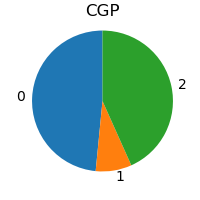

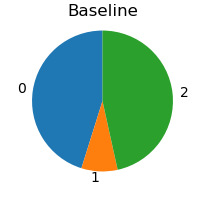

In [94]:
import matplotlib.pyplot as plt

labels = ['0', '1', '2']
sizes = [98, 18, 101]
plt.figure(figsize=(2, 2))
plt.pie(sizes, labels=labels, startangle=90)
plt.title('Baseline')
plt.axis('equal')  # Equal aspect ratio ensures a circle.
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure3_revised/{NrSubtype}_{DataType}_cluster_proportion_Baseline.svg")

labels = ['0', '1', '2']
sizes = [47, 8, 42]
plt.figure(figsize=(2, 2))
plt.pie(sizes, labels=labels, startangle=90)
plt.title('CGP')
plt.axis('equal')  # Equal aspect ratio ensures a circle.
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure3_revised/{NrSubtype}_{DataType}_cluster_proportion_CGP.svg")

plt.show()


### Neuron distances relative to cluster ID

In [ ]:
df_cluster = pd.read_excel(f'{Path(dpath)}/VigStates_Global_cluster.xlsx', index_col=0)
df_cluster = df_cluster[df_cluster['NeuronType'] == NrSubtype]
df_cluster['ClusterHDBSCAN'] = '0' if NrSubtype == 'L2_3_mice' else df_cluster['ClusterHDBSCAN']

In [ ]:
df_cluster_c = df_cluster.drop_duplicates(subset='Unit_ID', keep='first')
df_cluster_c = df_cluster_c.dropna(subset=['ClusterHDBSCAN'])

def extract_xy(coord_str):
    val = ast.literal_eval(coord_str)
    # Handle nested list: [[x], [y]]
    if isinstance(val[0], list):
        x, y = val[0][0], val[1][0]
    else:
        x, y = val[0], val[1]
    return pd.Series([x, y])

df_cluster_c[['x', 'y']] = df_cluster_c['UnitLocation'].apply(extract_xy)

within_dists_all = []
within_dists_c0 = []
within_dists_c1 = []
within_dists_c2 = []
between_dists_all = []
between_dists_c0 = []
between_dists_c1 = []
between_dists_c2 = []

for indiv_id, group in df_cluster_c.groupby('Mice'):
    coords = group[['x', 'y']].values
    labels = group['ClusterHDBSCAN'].values
    dist_matrix = squareform(pdist(coords))    
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            d = dist_matrix[i, j]
            if labels[i] == labels[j]:
                within_dists_all.append(d)
                if labels[i] == 0:
                    within_dists_c0.append(d)
                elif labels[i] == 1:
                    within_dists_c1.append(d)
                elif labels[i] == 2:
                    within_dists_c2.append(d)
            else:
                between_dists_all.append(d)
                if labels[i] == 0:
                    between_dists_c0.append(d)
                elif labels[i] == 1:
                    between_dists_c1.append(d)
                elif labels[i] == 2:
                    between_dists_c2.append(d)

# --- Plot distributions ---
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

plt.subplot(1,4,1)
sns.histplot(between_dists_c0, bins=30, binrange=(0, 600),color='black', label='0-others', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_c0, bins=30, binrange=(0, 600),color='orange', label='0-0', kde=True, stat="density", kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")
stat, p =ks_2samp(within_dists_c0, between_dists_c0)
plt.title(f"C0 = K-S Test: p = {p:.2f}")

plt.subplot(1,4,2)
sns.histplot(between_dists_c1, bins=30,binrange=(0, 600), color='black', label='1-others', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_c1, bins=30, binrange=(0, 600),color='blue', label='1-1', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")
stat, p =ks_2samp(within_dists_c1, between_dists_c1)
plt.title(f"C1 = K-S Test: p = {p:.2f}")

plt.subplot(1,4,3)
sns.histplot(between_dists_c2, bins=30, binrange=(0, 600),color='black', label='2-others', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_c2, bins=30, binrange=(0, 600), color='purple', label='2-2', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")
stat, p =ks_2samp(within_dists_c2, between_dists_c2)
plt.title(f"C2 = K-S Test: p = {p:.2f}")


plt.subplot(1,4,4)
sns.histplot(between_dists_all, bins=30, binrange=(0, 600),color='black', label='between', kde=True, stat="density", alpha=0.5, kde_kws={'bw_adjust': 0.5})
sns.histplot(within_dists_all, bins=30, binrange=(0, 600),color='red', label='within', kde=True, stat="density", kde_kws={'bw_adjust': 0.5})
plt.legend()
plt.xlabel("Distance in pixels")
plt.ylabel("Density")
stat, p =ks_2samp(within_dists_all, between_dists_all)
plt.title(f"All = K-S Test: p = {p:.2f}")
plt.tight_layout()

plt.show()

#dip, pval = diptest.diptest(np.array(within_dists_c1))
#print(f"C1 = Bimodal distribution Test: p = {pval:.2f}")

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_distance_percluster.svg", format='svg')

### Total activity (all vig states combined) for each cluster

In [ ]:
datatype=[ 'NormalizedAUC_calcium','DeconvSpikeMeanActivity', 'SpikeActivityHz', 'CalciumActivity']
fig, axes = plt.subplots(1, len(datatype), figsize=(8, 2))

for d,dt in enumerate(datatype): 
    data_ = df_cluster.pivot_table(index='Unit_ID', columns='ClusterHDBSCAN', values=dt, aggfunc='mean')   

    means = data_.mean()
    errors = data_.apply(lambda x: sem(x, nan_policy='omit'))
    plt.subplot(1,len(datatype),d+1)

    x_pos = np.arange(len(data_.columns))
    plt.bar(x_pos, means, yerr=errors, capsize=5, color='lightblue', edgecolor='black')

    # Plot individual dots
    for i, col in enumerate(data_.columns):
        y = data_[col].dropna()
        x = np.random.normal(loc=x_pos[i], scale=0.05, size=len(y))  # jitter to avoid overlap
        plt.scatter(x, y, color='black', alpha=0.7, s=30)

    plt.ylabel(dt)
    plt.tight_layout()
plt.show()

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_totactivity_percluster.svg", format='svg')

### Distribution Total activity (all vig states combined) for each cluster

In [ ]:
datatype=[ 'NormalizedAUC_calcium','DeconvSpikeMeanActivity', 'SpikeActivityHz', 'CalciumActivity']
xl=[30,0.02,0.3,1.5]
fig, axes = plt.subplots(1, len(datatype), figsize=(10, 3))

statt="count" #density or count

for d,dt in enumerate(datatype): 
    data_ = df_cluster.pivot_table(index='Unit_ID', columns='ClusterHDBSCAN', values=dt, aggfunc='mean')   

    means = data_.mean()
    errors = data_.apply(lambda x: sem(x, nan_policy='omit'))

    plt.subplot(1,len(datatype),d+1)
    sns.histplot(data_, bins=20, binrange=(0, xl[d]),color='black', kde=True, alpha=0.5, kde_kws={'bw_adjust': 0.5}, stat=statt)
    plt.xlabel(dt)
    plt.ylabel(statt)
    plt.xscale('linear') #linear, log, symlog, logit
    plt.tight_layout()
    
    # Force create legend from hue column
    handles, labels = plt.gca().get_legend_handles_labels()
    if not handles:
        handles = [mpatches.Patch(color=sns.color_palette()[i], label=group) 
                for i, group in enumerate(data_.columns)]
        plt.legend(handles=handles, title='Cluster')

plt.show()

In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_Distrib{statt}Totactivity_percluster.svg", format='svg')

### Activity per vig states for each cluster of all data types

In [ ]:
datatype=[ 'NormalizedAUC_calcium','DeconvSpikeMeanActivity', 'SpikeActivityHz', 'CalciumActivity']
fig, axes = plt.subplots(1, len(datatype), figsize=(12, 3))

for d,dt in enumerate(datatype):
        
    df = df_cluster.pivot_table(index='Unit_ID', columns=['ClusterHDBSCAN', 'Substate'], values=dt, aggfunc='mean') 
    try : df = df.drop(columns='undefined', level=1)
    except: pass
    try : df = df.drop(columns='IS', level=1)
    except: pass

    desired_order2=['AW','QW', 'NREM', 'REM']
    df = df.loc[:, df.columns.reindex(desired_order2, level=1)[0]]
    plt.subplot(1,len(datatype),d+1)
    # Compute means and SEM
    means = df.mean()
    errors = df.apply(lambda x: sem(x, nan_policy='omit'))

    # Setup bar positions
    n_groups = len(df.columns.levels[0])  # Number of groups (e.g., Group1, Group2)
    n_subcats = len(df.columns.levels[1])  # Number of subcategories (e.g., A, B, C, D)
    bar_width = 0.35
    group_width = n_subcats * bar_width + 0.2  # total width per group

    # X positions per bar
    positions = []
    tick_labels = []
    xtick_positions = []

    # Plot bars and lines connecting individual points for all subcategories within each group
    for g_idx, group in enumerate(df.columns.levels[0]):
        group_cols = [col for col in df.columns if col[0] == group]
        group_means = means[group_cols]
        group_errors = errors[group_cols]
        group_x = np.arange(len(group_cols)) * bar_width + g_idx * group_width

        # Plot bars for the group
        plt.bar(group_x, group_means, yerr=group_errors, capsize=4, width=bar_width,
            color='#51aeae', edgecolor='black')

        # Plot lines connecting corresponding individuals for each pair of subcategories
        for i in range(len(group_cols) - 1):  # Loop through subcategories to connect each pair
            # Get the data for the two subcategories
            group1_values = df[group_cols[i]].dropna()
            group2_values = df[group_cols[i + 1]].dropna()

            # Loop through corresponding individual values in the two subcategories and plot lines between them
            for j in range(min(len(group1_values), len(group2_values))):
                plt.plot([group_x[i], group_x[i + 1]], 
                        [group1_values.iloc[j], group2_values.iloc[j]], 
                        color='black', alpha=0.6, lw=1, marker='o', markersize=1)

        # Store positions for ticks
        positions.extend(group_x)
        tick_labels.extend([col[1] for col in group_cols])
        xtick_positions.extend(group_x)

    axes[d].set_xticks(xtick_positions)
    axes[d].set_xticklabels(tick_labels, rotation=45)

    # Add group labels (Group1, Group2) above bars
    group_centers = [i * group_width + (n_subcats - 1) * bar_width / 2 for i in range(n_groups)]
    for i, label in enumerate(df.columns.levels[0]):
        axes[d].text(group_centers[i], axes[d].get_ylim()[1]*1.02, label, ha='center', va='bottom', fontsize=12,)

    # Style
    axes[d].set_ylabel(dt)
    plt.tight_layout()
plt.show()


In [ ]:
plt.savefig(f"C:/Users/Manip2/Documents/Manuscripts/Figures_PNASreviews/Figure1_revised/{NrSubtype}_vigstactivity_percluster.svg", format='svg')